<h1> ResNet Architecture Implementation on CIFAR10</h1>
Task-1: AE640A Assignement 4

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import CIFAR100
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) #cifar10

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [3]:
# First implementing the ResNet model for CIFAR100 dataset
from torchvision.datasets.utils import download_url


#Dowload the dataset
#dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
#download_url(dataset_url, '.')

# #Extract from archive
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#    tar.extractall(path='./data')
    
#Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
print(train_ds)
print(valid_ds)
print(len(train_ds))
print(len(valid_ds))
print('total classes:', len(train_ds.classes))
print(train_ds.classes)

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./data/cifar10/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
50000
10000
total classes: 10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
batch_size = 400

In [6]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

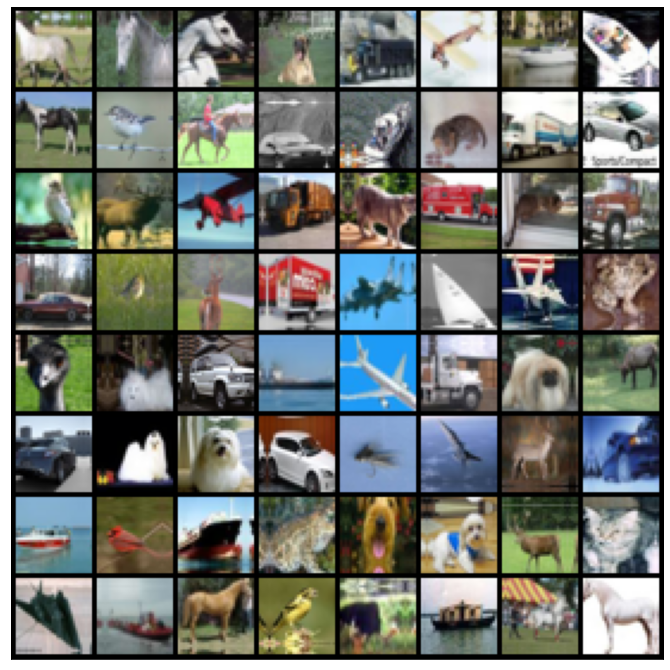

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cpu')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [13]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [14]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [15]:
# Functions and class for calculating the accuracy and loss
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
# Defining the ResNet architecture

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)         # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)      # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))  # 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True)    # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)    # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512))  # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                        nn.Flatten(),     # 512
                                        nn.Dropout(0.2),  
                                        nn.Linear(512, num_classes)) # 100
        
    def forward(self, xb):
        out1 = self.conv1(xb)
        out2 = self.conv2(out1)
        out3 = self.res1(out2) + out2
        out4 = self.conv3(out3)
        out5 = self.conv4(out4)
        out6 = self.res2(out5) + out5
        out = self.classifier(out6)
        return out

In [17]:
model = to_device(ResNet9(3, 100), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()      
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
torch.cuda.is_available()

False

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.5887131690979, 'val_acc': 0.0025961538776755333}]

In [21]:
epochs = 50
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-6
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "C:\Users\91809\.conda\envs\Tensorflow\lib\site-packages\torch\utils\data\_utils\worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\91809\.conda\envs\Tensorflow\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\91809\.conda\envs\Tensorflow\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\91809\.conda\envs\Tensorflow\lib\site-packages\torchvision\datasets\folder.py", line 230, in __getitem__
    sample = self.loader(path)
  File "C:\Users\91809\.conda\envs\Tensorflow\lib\site-packages\torchvision\datasets\folder.py", line 269, in default_loader
    return pil_loader(path)
  File "C:\Users\91809\.conda\envs\Tensorflow\lib\site-packages\torchvision\datasets\folder.py", line 248, in pil_loader
    img = Image.open(f)
  File "C:\Users\91809\.conda\envs\Tensorflow\lib\site-packages\PIL\Image.py", line 2967, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='./data/cifar10/train\\bird\\1101.png'>


In [ ]:
epochs = 60
max_lr = 0.02
grad_clip = 0.1
weight_decay = 5e-5
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00094, train_loss: 4.0050, val_loss: 3.4546, val_acc: 0.1734
Epoch [1], last_lr: 0.00137, train_loss: 3.2385, val_loss: 2.8223, val_acc: 0.2815
Epoch [2], last_lr: 0.00208, train_loss: 2.7580, val_loss: 2.4460, val_acc: 0.3585
Epoch [3], last_lr: 0.00304, train_loss: 2.4066, val_loss: 2.5751, val_acc: 0.3516
Epoch [4], last_lr: 0.00422, train_loss: 2.1600, val_loss: 2.4945, val_acc: 0.3791
Epoch [5], last_lr: 0.00559, train_loss: 1.9500, val_loss: 2.1103, val_acc: 0.4390
Epoch [6], last_lr: 0.00711, train_loss: 1.7793, val_loss: 1.9942, val_acc: 0.4667
Epoch [7], last_lr: 0.00873, train_loss: 1.6507, val_loss: 2.1495, val_acc: 0.4504
Epoch [8], last_lr: 0.01039, train_loss: 1.5784, val_loss: 1.9285, val_acc: 0.4896
Epoch [9], last_lr: 0.01206, train_loss: 1.5476, val_loss: 1.7744, val_acc: 0.5244
Epoch [10], last_lr: 0.01368, train_loss: 1.5511, val_loss: 1.6874, val_acc: 0.5312
Epoch [11], last_lr: 0.01520, train_loss: 1.5287, val_loss: 2.1541, val_acc: 0.4480
Ep

In [ ]:
epochs = 60
max_lr = 0.01
grad_clip = 0.1
weight_decay = 5e-5
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

In [ ]:
train_time='23:00'

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.